### Topic 1: Structural Properties of LADs
# Similarities between cells

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from scipy.signal import gaussian, fftconvolve
from matplotlib import gridspec
from scipy import signal
from scipy import stats

import sys
sys.path.append('../../combining_all_data/bin/')
sys.path.append('../bin/')
from preimplantation_toolkit import *
import preimplantation_load_data as ld

rs = np.random.RandomState()
rs.seed(42)

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

FIGOUTDIR = '../output/figures/4_Preimplantation.other_constructs.part3.metric_of_similarity.different_constructs_at_2cell_stage/'

In [3]:
! mkdir -p $FIGOUTDIR || true;

In [4]:
HOME = '/Users/f.rang/surfdrive/Kind/data/'

BINSIZE = 1000000
MINMAP_PER_KB = 1
MINMAP = int(MINMAP_PER_KB * BINSIZE / 1000)

ANNOFN = '../../combining_all_data/metadata/FR230814.samplesheet.tsv'
COLORFN = '../colors/manuscript_colors.tsv'

COUNTS = '../../combining_all_data/data/damid_counts/FR230814.DamID.sample_counts.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
BINARY = '../../combining_all_data/data/damid_binary/FR230814.DamID.sample_smooth_binary.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
CONTFC = '../../combining_all_data/data/damid_CF/FR230814.DamID.contact_frequency.{construct}.{stage}.{treatment}.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
INSILICO = '../../combining_all_data/data/damid_insilico/FR230814.DamID.insilico_counts.{construct}.{stage}.{treatment}.{genotype}.{sample}_samples.damid_pass.binsize_{binsize:d}.hdf5'
ALLELEFILTFN = '../../combining_all_data/data/damid_allelic_filter/FR230814.allelic_filter_based_on_visibility_and_bias.{genotype}.binsize_{binsize:d}.hdf5'

MAPFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.bowtie2_very_sensitive_N1.readlength_65.counts.pos.hdf5"
POSFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.posarray.hdf5"

# 1. Loading Kind data

In [5]:
color_dict = ld.load_color_dict(COLORFN)

## 1.1 Loading samplesheet

In [6]:
chrom_order = [str(c) for c in range(1,20)] + ['X', 'Y']
construct_order = ['Dam-Lmnb1', 'Dam-only', 'Dam-aH3K27me3', 'Dam-Cbx1(CD)', 'Cbx1(FL)-Dam']

In [7]:
anno = pd.read_csv(ANNOFN, sep='\t', dtype={'number_embryos': str})

## select samples passing quality filters
anno = anno[anno.DamID_PASS]

## select conditions of interest
anno = anno[anno['fusion_construct'].isin(construct_order)]
anno = anno[anno['stage'] == '2cell']
anno = anno[anno['treatment'] == 'no_treatment']
anno = anno[anno['genotype'] == 'homozygous']
anno = anno[anno.cellcount == 1]
anno = anno.set_index(anno['damid_name'])

anno.head()

,runid,illumina_index,damid2_adapter_number,celseq2_adapter_number,cellcount,construct,fusion_construct,stage,treatment,genotype,...,nGenes,nTranscripts,nTranscripts_maternal,nTranscripts_paternal,allelic_celseq_balance,nERCC,nMito,DamID_PASS,DamID_PASS_allelic,CELseq_PASS
damid_name,,,,,,,,,,,,,,,,,,,,,
KIN1971.index03.DamID2_BC_001,KIN1971,3,1,0,1,Lmnb1,Dam-Lmnb1,2cell,no_treatment,homozygous,...,0,0,NaN,NaN,NaN,0,0,True,True,False
KIN1971.index03.DamID2_BC_009,KIN1971,3,9,0,1,Lmnb1,Dam-Lmnb1,2cell,no_treatment,homozygous,...,0,0,NaN,NaN,NaN,0,0,True,True,False
KIN1971.index03.DamID2_BC_017,KIN1971,3,17,0,1,Lmnb1,Dam-Lmnb1,2cell,no_treatment,homozygous,...,0,0,NaN,NaN,NaN,0,0,True,True,False
KIN1971.index03.DamID2_BC_025,KIN1971,3,25,0,1,Lmnb1,Dam-Lmnb1,2cell,no_treatment,homozygous,...,0,0,NaN,NaN,NaN,0,0,True,True,False
KIN1971.index03.DamID2_BC_033,KIN1971,3,33,0,1,Lmnb1,Dam-Lmnb1,2cell,no_treatment,homozygous,...,0,0,NaN,NaN,NaN,0,0,True,True,False


## 1.2 Loading mappability

In [8]:
mapab = ld.load_mappability(POSFN, MAPFN, chrom_order, BINSIZE)

## 1.3 Loading data

__DamID sample counts__

In [9]:
damid_counts = ld.load_sample_damid_counts(COUNTS, anno, BINSIZE, chrom_order)

Cbx1(FL)-Dam homozygous
Dam-Cbx1(CD) homozygous
Dam-Lmnb1 homozygous
Dam-aH3K27me3 homozygous
Dam-only homozygous


__DamID sample binary signal__

In [10]:
damid_binary = ld.load_sample_damid_binary(BINARY, anno, BINSIZE, chrom_order)

Loading Dam-normalized binary data for Cbx1(FL)-Dam (homozygous) data
Cbx1(FL)-Dam homozygous
Loading Dam-normalized binary data for Dam-Cbx1(CD) (homozygous) data
Dam-Cbx1(CD) homozygous
Dam-Lmnb1 homozygous
Loading Dam-normalized binary data for Dam-aH3K27me3 (homozygous) data
Dam-aH3K27me3 homozygous
Dam-only homozygous


## 1.4 Downsampling single-cell counts

In [11]:
downsample_threshold_ls = [10000, 15000, 20000, 25000, 30000, 35000, 40000]

In [12]:
damid_counts_down = {t: dict() for t in downsample_threshold_ls}
np.random.seed(1)

for downtarget in downsample_threshold_ls:
    print('downsample threshold: ', downtarget)
    for sample, row in tqdm(anno.iterrows(), total=len(anno)):
        if 'KIN' not in sample:
            print(row)

        sample_pass = (row['unique_damid_counts'] >= downtarget)

        if not sample_pass:
            continue

        # downsample
        counts = damid_counts[sample]
        downcounts = downsample_counts(counts, downtarget)
        damid_counts_down[downtarget][sample] = downcounts

downsample threshold:  10000


  0%|          | 0/368 [00:00<?, ?it/s]

downsample threshold:  15000


  0%|          | 0/368 [00:00<?, ?it/s]

downsample threshold:  20000


  0%|          | 0/368 [00:00<?, ?it/s]

downsample threshold:  25000


  0%|          | 0/368 [00:00<?, ?it/s]

downsample threshold:  30000


  0%|          | 0/368 [00:00<?, ?it/s]

downsample threshold:  35000


  0%|          | 0/368 [00:00<?, ?it/s]

downsample threshold:  40000


  0%|          | 0/368 [00:00<?, ?it/s]

## 1.5 Converting downsampled counts to binary contacts

In [13]:
SMOOTH_STD = 150000
W = gaussian(np.ceil(SMOOTH_STD / BINSIZE * 2 / 2) * 2 + 1, SMOOTH_STD / BINSIZE)
W /= W.sum()
W

array([2.23363144e-10, 1.00000000e+00, 2.23363144e-10])

### Generating Dam-only control

In [14]:
# normalize and smooth Dam-only control
dam_control = {c: np.zeros_like(mapab[c]) for c in chrom_order}
for sample in anno[anno.fusion_construct=='Dam-only'].index.values:
    dam_control = {c: dam_control[c] + damid_counts[sample][c] for c in chrom_order}
dam_control_rpkm = rpkm_normalize(dam_control, BINSIZE)
dam_control_smooth = {c: fftconvolve(dam_control_rpkm[c], W, mode='same') for c in chrom_order}

In [15]:
### Option 2: compute single-cell average of Dam-only samples
dam_control_smooth2 = {c: list() for c in chrom_order}
for sample, row in anno[(anno.fusion_construct=='Dam-only')].iterrows():
    d = row['unique_damid_counts']
    lognorm = {c: np.log1p(damid_counts[sample][c] / d * 1e4) for c in chrom_order}
    lognorm_smooth = {c: fftconvolve(lognorm[c], W, mode='same') for c in chrom_order}
    for c in chrom_order:
        dam_control_smooth2[c].append(lognorm_smooth[c])

for c in chrom_order:
    dam_control_smooth2[c] = np.array(dam_control_smooth2[c]).mean(axis=0)

In [16]:
BINARY_DAMNORM_THRESHOLD = 1.1

In [17]:
damid_binary_down = {t: dict() for t in downsample_threshold_ls}

# normalize and smooth mappability
mapab_rpkm = rpkm_normalize(mapab, binsize=BINSIZE)
mapab_smooth = {c: fftconvolve(mapab_rpkm[c], W, mode='same') for c in chrom_order}

for downtarget in damid_counts_down:

    # iterate over samples
    for sample, row in anno.iterrows():
        if sample not in damid_counts_down[downtarget].keys():
            continue

        counts = damid_counts_down[downtarget][sample]

        if row['fusion_construct'] in ['Dam-Lmnb1', 'Dam-only']:
            rpkm = rpkm_normalize(counts, binsize=BINSIZE)
            rpkm_smooth = {c: fftconvolve(rpkm[c], W, mode='same') for c in chrom_order}
            b = {c: (rpkm_smooth[c] > mapab_smooth[c]).astype(int) for c in chrom_order}
        else:
            d = sum([counts[c].sum() for c in chrom_order])
            lognorm = {c: np.log1p(counts[c] / d * 1e4) for c in chrom_order}
            lognorm_smooth = {c: fftconvolve(lognorm[c], W, mode='same') for c in chrom_order}
            b = {c: ((lognorm_smooth[c] - dam_control_smooth2[c]) > np.log(BINARY_DAMNORM_THRESHOLD)).astype(int) for c in chrom_order}

        for c in chrom_order:
            b[c][mapab[c]==0] = 0

        damid_binary_down[downtarget][sample] = b

## 1.6 Generating a simulated single-cell dataset by downsampling _in silico_ populations

In [18]:
SMOOTH_STD = 150000
W = gaussian(np.ceil(SMOOTH_STD / BINSIZE * 2 / 2) * 2 + 1, SMOOTH_STD / BINSIZE)
W /= W.sum()
W

array([2.23363144e-10, 1.00000000e+00, 2.23363144e-10])

In [19]:
select_chroms = chrom_order
damid_counts_sim = dict()
damid_binary_sim = dict()
damid_counts_down_sim = {t: dict() for t in damid_counts_down.keys()}
damid_binary_down_sim = {t: dict() for t in damid_binary_down.keys()}

# compute RPKM normalized mappability
# normalize and smooth mappability
mapab_rpkm = rpkm_normalize(mapab, binsize=BINSIZE)
mapab_smooth = {c: fftconvolve(mapab_rpkm[c], W, mode='same') for c in chrom_order}

seed = 0

# iterate over samples and generate single-cell binary
for (construct, runid), df in anno.groupby(['fusion_construct', 'runid']):
    
    if len(df) == 0:
        continue

    samples = df.index.values

    # generate in silico combined counts for this run
    pop = {c: np.zeros(len(mapab[c])) for c in select_chroms}
    for sample in samples:
        pop = {c: pop[c] + damid_counts[sample][c] for c in select_chroms}
    Tpop = int(sum([pop[c].sum() for c in select_chroms]))


    # iterate over single-cell samples and generate downsampled equivalents
    print(construct, runid, Tpop, len(samples))
    for sample in samples:

        # determine depth of this sample
        t = sum([damid_counts[sample][c].sum() for c in select_chroms])

        # create downsampled simulated single-cell sample from population
        counts = downsample_counts(pop, downtarget=t, seed=seed)
        seed += 1
        damid_counts_sim[sample] = counts
        
       # binarization based on mappability-normalized or Dam-only data
        if construct in ['Dam-Lmnb1', 'Dam-only']:
            rpkm = rpkm_normalize(counts, binsize=BINSIZE)
            rpkm_smooth = {c: fftconvolve(rpkm[c], W, mode='same') for c in chrom_order}
            b = {c: (rpkm_smooth[c] > mapab_smooth[c]).astype(int) for c in chrom_order}
        else:
            d = sum([counts[c].sum() for c in chrom_order])
            lognorm = {c: np.log1p(counts[c] / d * 1e4) for c in chrom_order}
            lognorm_smooth = {c: fftconvolve(lognorm[c], W, mode='same') for c in chrom_order}
            b = {c: ((lognorm_smooth[c] - dam_control_smooth2[c]) > np.log(BINARY_DAMNORM_THRESHOLD)).astype(int) for c in chrom_order}
        for c in select_chroms:
            b[c][mapab[c]==0] = 0
            
        damid_binary_sim[sample] = b
        
        # do the same for the downsampled cases
        for downtarget in damid_counts_down:
            if sample in damid_counts_down[downtarget]:
                t = sum([damid_counts_down[downtarget][sample][c].sum() for c in select_chroms])

                # create downsampled simulated single-cell sample from population
                counts = downsample_counts(pop, downtarget=t, seed=seed)
                damid_counts_down_sim[downtarget][sample] = counts
                
                # binarization based on mappability-normalized or Dam-only data
                if construct in ['Dam-Lmnb1', 'Dam-only']:
                    rpkm = rpkm_normalize(counts, binsize=BINSIZE)
                    rpkm_smooth = {c: fftconvolve(rpkm[c], W, mode='same') for c in chrom_order}
                    b = {c: (rpkm_smooth[c] > mapab_smooth[c]).astype(int) for c in chrom_order}
                else:
                    d = sum([counts[c].sum() for c in chrom_order])
                    lognorm = {c: np.log1p(counts[c] / d * 1e4) for c in chrom_order}
                    lognorm_smooth = {c: fftconvolve(lognorm[c], W, mode='same') for c in chrom_order}
                    b = {c: ((lognorm_smooth[c] - dam_control_smooth2[c]) > np.log(BINARY_DAMNORM_THRESHOLD)).astype(int) for c in chrom_order}

                for c in select_chroms:
                    b[c][mapab[c]==0] = 0
                damid_binary_down_sim[downtarget][sample] = b


Cbx1(FL)-Dam KIN8928 605068 27
Dam-Cbx1(CD) KIN7553 731539 37
Dam-Lmnb1 KIN1971 1298675 11
Dam-Lmnb1 KIN2477 13644211 66
Dam-Lmnb1 KIN3408 4588457 43
Dam-Lmnb1 KIN3600 6067573 31
Dam-Lmnb1 KIN6284 5760960 45
Dam-Lmnb1 KIN9024 13266 1
Dam-aH3K27me3 KIN2577 521481 6
Dam-aH3K27me3 KIN3600 1254155 24
Dam-only KIN2477 4293546 31
Dam-only KIN7167 2112319 46


# 2. Compute cell-to-cell similarities

Only take somatic chromosomes into account

In [20]:
from collections import defaultdict

In [21]:
from sklearn.metrics import pairwise_distances

## 2.1 Compute similarities

In [22]:
select_chroms = np.arange(1,20).astype(str)
pairwise_similarity_scores = dict()
m_ind = np.concatenate([mapab[c] for c in select_chroms]) > MINMAP


dataset_dict = {
    'full_orig': damid_binary,
    'full_sim': damid_binary_sim
}

for downtarget in damid_binary_down:
    dataset_dict['down_%d_orig' % downtarget] = damid_binary_down[downtarget]
    dataset_dict['down_%d_sim' % downtarget] = damid_binary_down_sim[downtarget]

for construct, anno_df in anno[anno.cellcount == 1].groupby('fusion_construct'):
    
    samples = anno_df.index.values
    result_ls = list()

    for ds in dataset_dict:

        tmp = np.array(list(dataset_dict[ds].keys()))
        select_ind = np.isin(samples, tmp)
        select_samples = samples[select_ind]

        ## select binary data
        D = list()
        for s in select_samples: # somatic chromosomes only
            y = np.concatenate([dataset_dict[ds][s][c] for c in select_chroms])[m_ind]
            D.append(y)
        D = np.array(D)

        if D.shape[0] < 2:
            continue

        print(construct, ds, len(select_samples))

        ## jaccard on binary data
        C = 1 - pairwise_distances(D.astype(bool), metric='jaccard')
        df = pd.DataFrame(C, columns=select_samples, index=select_samples).reset_index().rename(columns={'index': 'sample1'})
        df = df.melt(id_vars='sample1', var_name='sample2', value_name='similarity')
        df['metric'] = 'Jaccard'
        df['dataset'] = ds
        result_ls.append(df)

        ## yule on binary data
        C = 1 - pairwise_distances(D.astype(bool), metric='yule')
        df = pd.DataFrame(C, columns=select_samples, index=select_samples).reset_index().rename(columns={'index': 'sample1'})
        df = df.melt(id_vars='sample1', var_name='sample2', value_name='similarity')
        df['metric'] = 'Yule'
        df['dataset'] = ds
        result_ls.append(df)
            
    if len(result_ls) == 1:
        result_df = result_ls[0]
    elif len(result_ls) == 0:
        continue
    else:
        result_df = pd.concat(result_ls, axis=0)
    pairwise_similarity_scores[construct] = result_df

Cbx1(FL)-Dam full_orig 27
Cbx1(FL)-Dam full_sim 27
Cbx1(FL)-Dam down_10000_orig 24
Cbx1(FL)-Dam down_10000_sim 24
Cbx1(FL)-Dam down_15000_orig 18
Cbx1(FL)-Dam down_15000_sim 18
Cbx1(FL)-Dam down_20000_orig 14
Cbx1(FL)-Dam down_20000_sim 14
Cbx1(FL)-Dam down_25000_orig 11
Cbx1(FL)-Dam down_25000_sim 11
Cbx1(FL)-Dam down_30000_orig 6
Cbx1(FL)-Dam down_30000_sim 6
Cbx1(FL)-Dam down_35000_orig 4
Cbx1(FL)-Dam down_35000_sim 4
Cbx1(FL)-Dam down_40000_orig 2
Cbx1(FL)-Dam down_40000_sim 2
Dam-Cbx1(CD) full_orig 37
Dam-Cbx1(CD) full_sim 37
Dam-Cbx1(CD) down_10000_orig 28
Dam-Cbx1(CD) down_10000_sim 28
Dam-Cbx1(CD) down_15000_orig 20
Dam-Cbx1(CD) down_15000_sim 20
Dam-Cbx1(CD) down_20000_orig 11
Dam-Cbx1(CD) down_20000_sim 11
Dam-Cbx1(CD) down_25000_orig 8
Dam-Cbx1(CD) down_25000_sim 8
Dam-Cbx1(CD) down_30000_orig 6
Dam-Cbx1(CD) down_30000_sim 6
Dam-Cbx1(CD) down_35000_orig 4
Dam-Cbx1(CD) down_35000_sim 4
Dam-Cbx1(CD) down_40000_orig 4
Dam-Cbx1(CD) down_40000_sim 4
Dam-Lmnb1 full_orig 197
Dam-Lm

## 2.2 Inspect relationship between depth and similarity scores

In [23]:
pairwise_similarity_scores.keys()

dict_keys(['Cbx1(FL)-Dam', 'Dam-Cbx1(CD)', 'Dam-Lmnb1', 'Dam-aH3K27me3', 'Dam-only'])

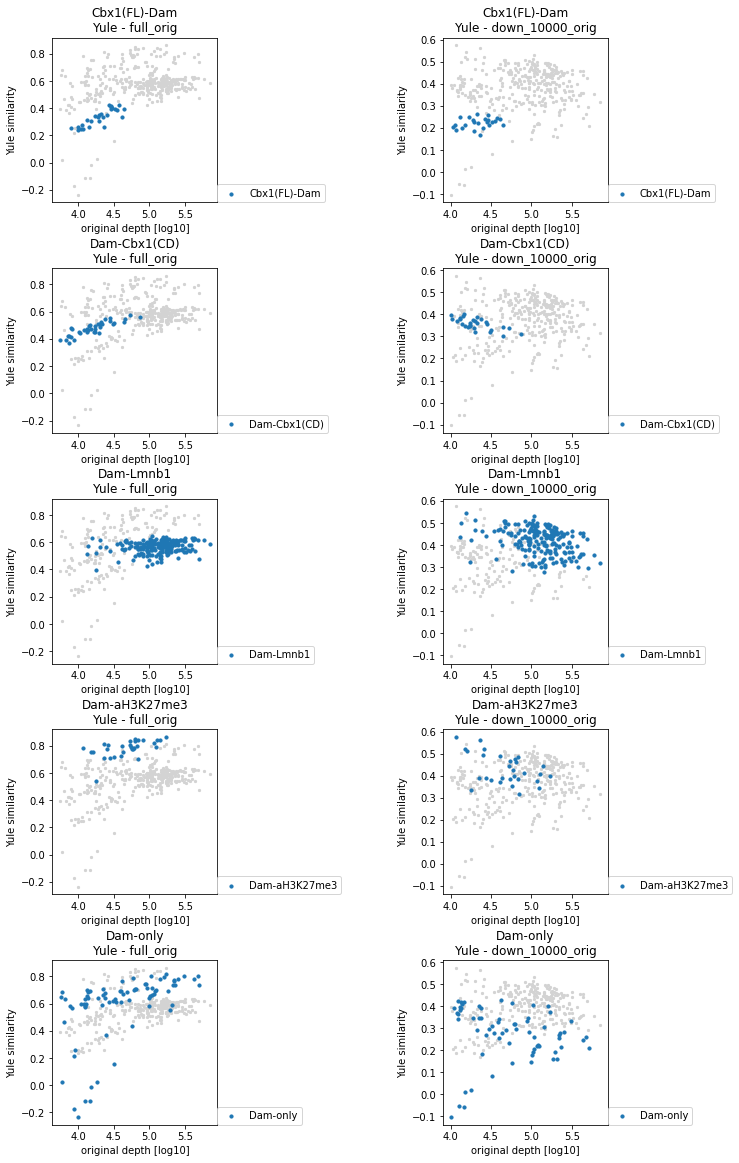

In [24]:
g_anno = anno.groupby('fusion_construct')
metrics_to_plot = [
    ('Yule', 'full_orig'), ('Yule', 'down_10000_orig') 
#     ('Jaccard', 'full_orig'), ('Jaccard', 'down_orig')
]

nrow = len(list(g_anno))
ncol = len(metrics_to_plot)

fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*6, nrow*4))
plt.subplots_adjust(hspace=.4, wspace=.4)
irow = -1

## collect plottables
plot_dict = dict()
for info in pairwise_similarity_scores:
    plot_dict[info] = dict()
    
    for comb in metrics_to_plot:
        
        to_plot = pairwise_similarity_scores[info].copy()
        to_plot = to_plot[(to_plot['metric'] == comb[0]) & (to_plot['dataset'] == comb[1])]
        to_plot = to_plot[to_plot['sample1'] != to_plot['sample2']]
        
        if len(to_plot) == 0:
            continue
        
        to_plot = to_plot.groupby(['sample1']).agg({'similarity': np.median}).reset_index()
        to_plot['depth'] = anno.loc[to_plot['sample1'].values, 'unique_damid_counts'].values
        plot_dict[info][comb] = to_plot
        

for construct, _ in g_anno:
    irow += 1
    
    for icol, comb in enumerate(metrics_to_plot):
        
        ax = axes[irow,icol]
        ax.set_title('%s\n%s - %s' % (construct, comb[0], comb[1]))
        ax.set_xlabel('original depth [log10]')
        ax.set_ylabel('%s similarity' % comb[0])
        ax.set_box_aspect(1)
        
        # plot other constructs
        for info in plot_dict:
            if info == construct:
                continue
            if comb not in plot_dict[info]:
                continue
            tmp = plot_dict[info][comb].copy()
            X = np.log10(tmp['depth'])
            Y = tmp['similarity']
            ax.scatter(X, Y, color='lightgrey', s=5)
            
        # plot current condition
        for info in plot_dict:
            if info != construct:
                continue
            if comb not in plot_dict[info]:
                continue
            tmp = plot_dict[info][comb].copy()
            X = np.log10(tmp['depth'])
            Y = tmp['similarity']
            ax.scatter(X, Y, s=10, label=info)
            
            

        ax.legend(loc=(1,0))
    

# 3. Cell-to-cell similarity per relevant sample set

## 3.1 Function to plot real and simulated data

In [25]:
def plot_real_and_simulated_data(to_plot, chrom, plot_downsampled=False, downtarget=0):
    
    # if plotting downsampled data, only plot samples with enough counts
    to_plot = to_plot.copy()
    if plot_downsampled:
        to_plot = to_plot[to_plot.unique_damid_counts >= downtarget]
        to_plot['DamID_PASS_allelic'] = to_plot[['maternal_damid_counts', 'paternal_damid_counts']].sum(axis=1) >= downtarget
    
    # group dataframe
    g_to_plot = to_plot.groupby('fusion_construct')
    
    # set up figure
    hr = list()
    for construct, df in g_to_plot:
        hr.append(30)
        hr.append(max(len(df),20))

    fig, axes = plt.subplots(len(hr), 2, figsize=(12, sum(hr)*0.05), gridspec_kw={'height_ratios': hr}, sharex=True)
    plt.subplots_adjust(hspace=.5)
    r_counter = 0

    # iterate over conditions and plot
    for construct, df in g_to_plot:

        samples = df.sort_values(by=['unique_damid_counts']).index.values

        if not plot_downsampled:
            tmp = {'original': damid_binary, 'simulated': damid_binary_sim}
            dataname = 'full counts'
        else:
            assert downtarget in damid_binary_down
            tmp = {'original': damid_binary_down[downtarget], 'simulated': damid_binary_down_sim[downtarget]}
            dataname = 'downsampled to {:,d}'.format(downtarget)

        for icol, data in enumerate(['original', 'simulated']):

            # plot single-cell heatmaps
            ax = axes[r_counter+1,icol]

            C = list()
            for s in samples:
                if s in tmp[data]:
                    C.append(tmp[data][s][chrom])
                else:
                    y = np.zeros_like(mapab[chrom]).astype(float)
                    y[:] = np.nan
                    C.append(y)
            C = np.array(C)
            C = np.atleast_2d(C)
            xmax = C.shape[1] * BINSIZE / 1e6
            ax.imshow(C, extent=[0,xmax,0,C.shape[0]], aspect='auto', cmap='binary', vmin=0, vmax=1, origin='lower')


            # plot CF
            ax = axes[r_counter,icol]
            Y = np.nanmean(C, axis=0)
            X = np.arange(0, len(Y)*BINSIZE, BINSIZE)/1e6
            ax.fill_between(X, 0, Y, lw=0, color=color_dict['fusion_construct'][construct])
            ax.set_title('%s\n%s (n = %d) - %s' % (construct, data, C.shape[0], dataname))
            ax.set_xlabel('chromosome %s [Mb]' % chrom)

        r_counter += 2

## 3.2 Function to plot similarity scores

In [26]:
def plot_similarity_scores(anno_select, select_thresh, metric):
    
    # determine number and order of conditions
    n_conditions = len(list(anno_select.groupby('fusion_construct')))

    # collect relevant data
    to_plot = list()
    dataselect_ls = ['full_orig', 'full_sim', 'down_%s_orig' % select_thresh, 'down_%s_sim' % select_thresh]

    for ds in dataselect_ls:

        for info, _ in anno_select.groupby('fusion_construct'):

            df = pairwise_similarity_scores[info].copy()

            ind = (df['sample1'] != df['sample2']) & (df['metric'] == metric) & (df['dataset'] == ds)
            df = df[ind]
            df['fusion_construct'] = anno_select.loc[df.sample1.values,'fusion_construct'].values
            df['is_downsampled'] = df['dataset'].str.contains('down')

            to_plot.append(df)

    to_plot = pd.concat(to_plot, axis=0)
    
    # set up plot
    nrow = 2
    ncol = 2
    fig, axes = plt.subplots(2, 3, figsize=(n_conditions*4, 10), gridspec_kw={'width_ratios': [2,1,1]})
    plt.subplots_adjust(hspace=1)
    irow = -1
    
    # plot results
    for is_down, df in to_plot.groupby('is_downsampled'):
        irow += 1

        ## plot original vs simulated
        ax = axes[irow,0]
        ax.set_title(is_down)
        sns.violinplot(x=df['fusion_construct'], y=df['similarity'], hue=df['dataset'], order=construct_order, ax=ax)
        ax.set_ylabel('%s similarity' % metric)

        if is_down:
            t = 'Rich samples, downsampled to %d' % select_thresh
        else:
            t = 'All samples, full counts'
        ax.set_title(t + '\ncell-cell similarity for original and simulated data')

        ## unstacking data
        df = df.copy().drop(columns=['metric'])
        df = df.set_index(['fusion_construct', 'is_downsampled', 'sample1', 'sample2', 'dataset']).unstack()
        df.columns = [c[1].split('_')[-1] for c in df.columns.values]
        df = df.reset_index()
        df['corrected'] = df['orig'] - df['sim']

        ## plot original
        ax = axes[irow,1]
        sns.violinplot(x=df['fusion_construct'], y=df['orig'], order=construct_order, ax=ax)
        ax.set_ylabel('original %s' % metric)
        ax.set_title(t + '\noriginal cell-cell similarity')

        ## plot corrected
        ax = axes[irow,2]
        sns.violinplot(x=df['fusion_construct'], y=df['corrected'], order=construct_order, ax=ax)
        ax.set_ylabel('corrected %s' % metric)
        ax.set_title(t + '\ncorrected cell-cell similarity')

        for ax in axes[irow,:]:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            ax.set_xlabel('')

## 3.3 Inspect results: Untreated homozygous samples

### Step 1: Determine appropriate downsampling depth

fusion_construct
Cbx1(FL)-Dam      24
Dam-Cbx1(CD)      28
Dam-Lmnb1        197
Dam-aH3K27me3     30
Dam-only          67
dtype: int64

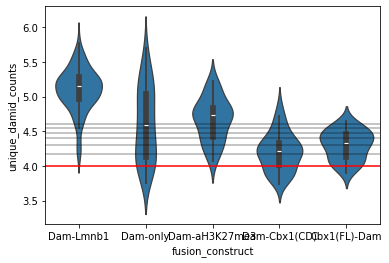

In [27]:
select_thresh = 10000

anno_select = anno.copy()
n_conditions = len(list(anno_select.groupby('fusion_construct')))
label_order = construct_order

fig, ax = plt.subplots()
sns.violinplot(x=anno_select['fusion_construct'], y=np.log10(anno_select['unique_damid_counts']))

for y in downsample_threshold_ls:
    if y == select_thresh:
        ax.axhline(np.log10(y), c='r')
    else:
        ax.axhline(np.log10(y), c='k', alpha=.3)
        
anno_select[anno_select.unique_damid_counts > select_thresh].groupby('fusion_construct').size()

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_51096/3986364019.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_51096/3986364019.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


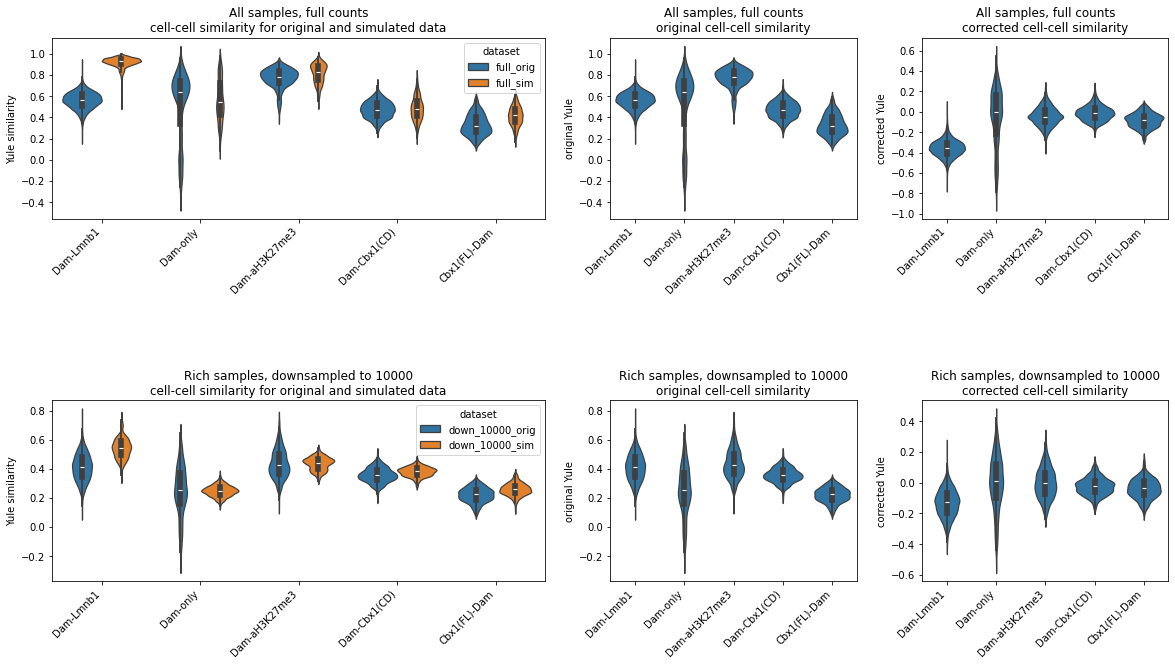

In [28]:
metric = 'Yule'
plot_similarity_scores(anno_select, select_thresh, metric)

# 4. Making nice plots

## 4.1 Function to collect statistical results

In [29]:
import itertools

In [30]:
def statistical_results_between_conditions(to_plot, plot_col):
    stat_dict = defaultdict(list)
    condition_ls = [info for info, _ in anno_select.groupby('fusion_construct')]

    for cond1, cond2 in itertools.combinations(condition_ls, 2):

        for i, cond in enumerate([cond1,cond2]):
            i += 1
            stat_dict['construct_%d'%i].append(cond)
            ind = (to_plot['fusion_construct']==cond)
            tmp = np.concatenate([to_plot.loc[ind,'sample1'].values, to_plot.loc[ind,'sample2'].values])
            stat_dict['n_samples_%d'%i].append(len(np.unique(tmp)))
            stat_dict['n_sample_pairs_%d'%i].append(ind.sum())

        
        ind1 = (to_plot['fusion_construct']==cond1)
        ind2 = (to_plot['fusion_construct']==cond2)
        A = to_plot.loc[ind1,plot_col].values
        B = to_plot.loc[ind2,plot_col].values
        
        stat_dict['median_1'].append(np.median(A))
        stat_dict['mean_1'].append(A.mean())
        stat_dict['std_1'].append(np.std(A))
        
        stat_dict['median_2'].append(np.median(B))
        stat_dict['mean_2'].append(B.mean())
        stat_dict['std_2'].append(np.std(B))
        
        s, p = stats.mannwhitneyu(A, B)
        stat_dict['MannWhitneyU_stat'].append(s)
        stat_dict['MannWhitneyU_pval'].append(p)
        
    stat_df = pd.DataFrame(stat_dict)
    return stat_df

## 4.2 Function to adjust y-limit to exclude outliers

In [31]:
def define_ylim(to_plot, groupcol, plot_col, current_ylim, n_std=5):

    min_ls = list()
    max_ls = list()
    
    for cat, df in to_plot.groupby(groupcol):
        
        m = np.mean(df[plot_col])
        s = np.std(df[plot_col])
        
        min_ls.append(m-n_std*s)
        max_ls.append(m+n_std*s)
        
    mn = max(min(min_ls),current_ylim[0])
    mx = min(max(max_ls),current_ylim[1])
    
    return (mn, mx)
        

## 4.3 Function to plot results

In [32]:
def plot_nice_similarity_scores(anno_select, metric, plot_downsampled, select_thresh, plot_col):
    
    assert plot_col in ['original', 'simulated', 'corrected']
    
    # determine number and order of conditions
    n_conditions = len(list(anno_select.groupby('fusion_construct')))

    # collect relevant data
    to_plot = list()
    if plot_downsampled:
        assert select_thresh in downsample_threshold_ls
        dataselect_ls = ['down_%s_orig' % select_thresh, 'down_%s_sim' % select_thresh]
    else:
        dataselect_ls = ['full_orig', 'full_sim']

    for ds in dataselect_ls:

        for construct, _ in anno_select.groupby('fusion_construct'):

            df = pairwise_similarity_scores[construct].copy()
            ind = (df['sample1'] != df['sample2']) & (df['metric'] == metric) & (df['dataset'] == ds)
            df = df[ind]
            for col in ['fusion_construct']:
                df[col] = anno_select.loc[df.sample1.values,col].values
            df['dataset'] = df['dataset'].apply(func = lambda d: 'original' if 'orig' in d else 'simulated')

            to_plot.append(df)

    to_plot = pd.concat(to_plot, axis=0)
    
    
    to_plot = to_plot.drop(columns=['metric'])
    to_plot = to_plot.set_index(['fusion_construct', 'sample1', 'sample2', 'dataset']).unstack()
    to_plot.columns = [c[1] for c in to_plot.columns.values]
    to_plot = to_plot.reset_index()
    to_plot['corrected'] = to_plot['original'] - to_plot['simulated']
    to_plot['sample_pair'] = to_plot.apply(axis=1, func=lambda r: ':'.join(sorted([r['sample1'], r['sample2']])))
    ind = to_plot['sample_pair'].duplicated()
    assert ind.mean() == 0.5
    to_plot = to_plot[~ind]
    
    
    # set up plot
    fig, ax = plt.subplots(figsize=(n_conditions, 4))

    ## plot
    sns.violinplot(
        x=to_plot['fusion_construct'], y=to_plot[plot_col], hue=to_plot['fusion_construct'], 
        order=construct_order, ax=ax, dodge=False, palette=color_dict['fusion_construct']
    )

    # format plot
    ax.set_ylabel('%s %s' % (plot_col, metric))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.axhline(0, c='k', alpha=0.2)
    
    if plot_downsampled:
        t = 'cell-to-cell similarity\n{} data - downsampled to {:,} counts'.format(plot_col, select_thresh)
    else:
        t = 'cell-to-cell similarity\n{} data - Full data'.format(plot_col)
    ax.set_title(t)
    
    # adjust yrange to exclude outliers
    newlim = define_ylim(to_plot, 'fusion_construct', plot_col, ax.get_ylim())
    ax.set_ylim(newlim)
    
    # collect stistical constructrmation
    stat_df = statistical_results_between_conditions(to_plot, plot_col)
    stat_df['metric'] = metric
    if plot_downsampled:
        stat_df['downsampled_to'] = select_thresh
    stat_df['dataset'] = plot_col
    
    return stat_df

## 4.4 Plot results per experiment

In [38]:
outfmt = 'similarity_scores.2cell_untreated_all_construct.{dataset}_{metric}.{downsample}.binsize_{binsize:d}.pdf'

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_51096/3091579989.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


../output/figures/4_Preimplantation.other_constructs.part3.metric_of_similarity.different_constructs_at_2cell_stage/similarity_scores.2cell_untreated_all_construct.corrected_Yule.full_counts.binsize_1000000.pdf


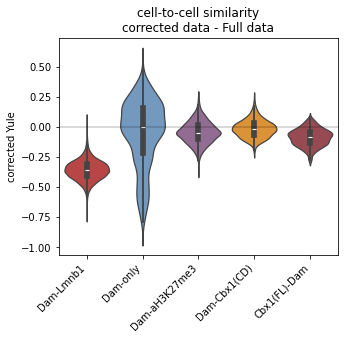

In [40]:
anno_select = anno.copy()
metric = 'Yule'
plot_downsampled = False
select_thresh = 100000

stat_df = plot_nice_similarity_scores(
    anno_select, metric, plot_downsampled, select_thresh, 'corrected'
)

outfn = FIGOUTDIR + outfmt.format(dataset='corrected', metric=metric, downsample='full_counts', binsize=BINSIZE)
print(outfn)
plt.savefig(outfn, bbox_inches='tight')

outfn = outfn.replace('.pdf', '.stats.tsv')
stat_df.to_csv(outfn, sep='\t', header=True, index=False)

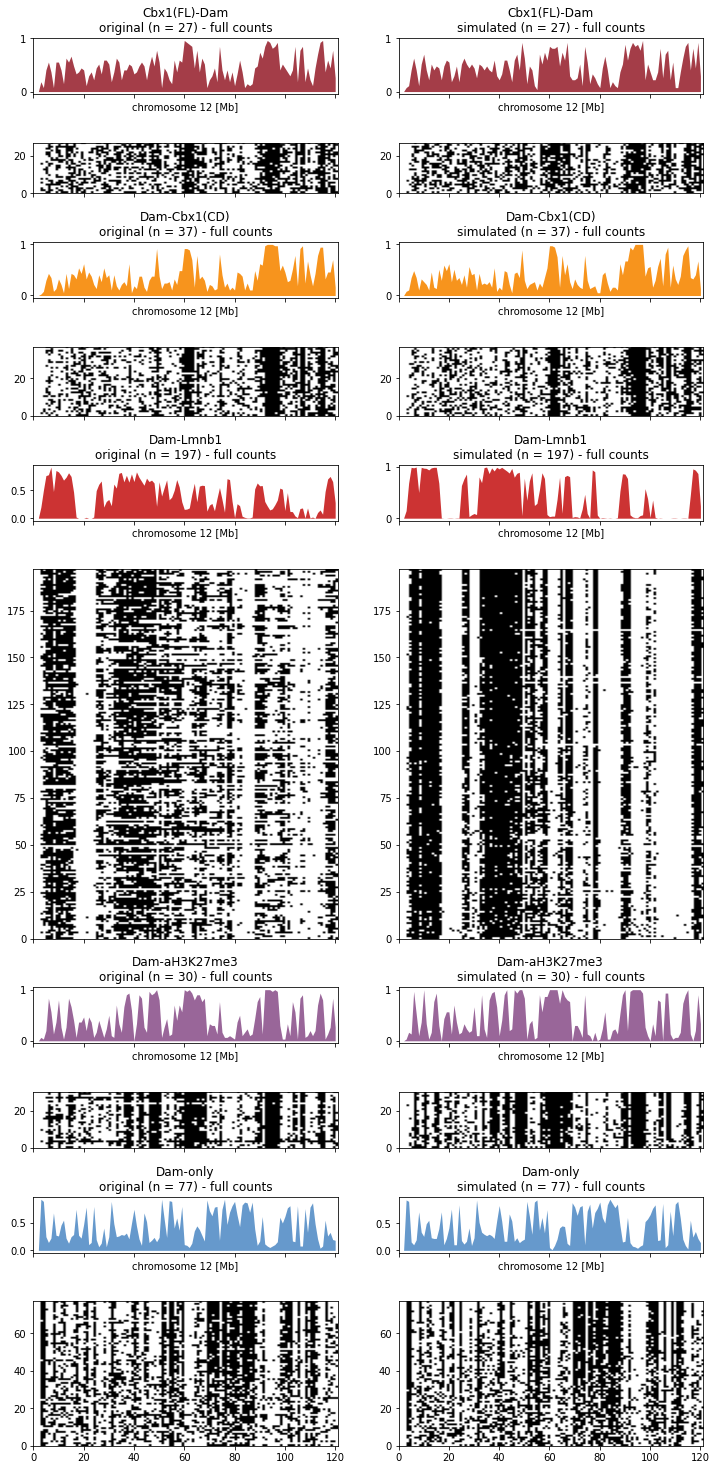

In [37]:
outfmt = FIGOUTDIR + 'original_vs_simulated_contacts.heatmaps.{dataset}.chromosome_{chrom}.binsize_{binsize:d}.pdf'

for chrom in ['8', '10', '12', '13', '17']:
    
    plot_real_and_simulated_data(anno_select, chrom, plot_downsampled=False, downtarget=0)
    
    outfn = outfmt.format(dataset='full_counts', chrom=chrom, binsize=BINSIZE)
    plt.savefig(outfn, bbox_inches='tight')
    if chrom == '12':
        plt.show()
    plt.close()